For some types of observations, you may not need to know about the absolute physical flux of an object (e.g., normalized transit light curves). There are many situations where the precise physical flux is useful, though, necessitating a "flux calibration." This calibration finds the wavelength-dependent conversion between detector counts and physical flux units.

In this section, we show how ```specsuite``` can help automate this process for certain well-characterized flux calibrator stars.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        In our "Setup Code," we are loading in a CSV with a pre-generated wavelength solution.
    </p>
</div>

In [1]:
import specsuite as ss
import pandas as pd
import numpy as np

DATA_REGION = (300, 600)
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
)

arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT
) - bias

fluxcal = ss.average_matching_files(
    path = CAL_PATH,
    tag = "fluxcal",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

# Performs a simple flatfield correction
fluxcal = ss.flatfield_correction(fluxcal, flat)

# Generates a decent warp model for our sample KOSMOS data
locs, _ = ss.find_cal_lines(arclamp, std_variation=200)
warp_model = ss.generate_warp_model(arclamp, locs)
background = ss.extract_background(fluxcal, warp_model, mask_region=(150, 200))[0]
fluxcal -= background

### Extracts flux from image
flux_extracted, uncertainty_extracted = ss.boxcar_extraction(fluxcal, background, RN=6.0)

df = pd.read_csv("../data/KOSMOS/calibrations/APO_red_wavecal.csv")
p_wavecal = np.poly1d(
    np.polyfit(
        x = df["pixel positions"],
        y = df["wavelengths (AA)"],
        deg = 2,
    )
)

pix = np.array(range(len(fluxcal[0])))
measured_wavs = p_wavecal(pix)

## **Basic Usage**
### _Loading Model Spectra_
The first step in a flux calibration involves retrieving the known SED of your calibration star (for our example, we will use GD153). If you do not have a model SED handy, it might be one of many publicly-available SED's listed on **[STScI's "Calspec" page (See Table 1)](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec#h4-CK-276cbd94-d263-4d3d-9113-986b0ff9e69e)**. If your star is found on the linked page, you can quickly load the model SED into Python using the following code...

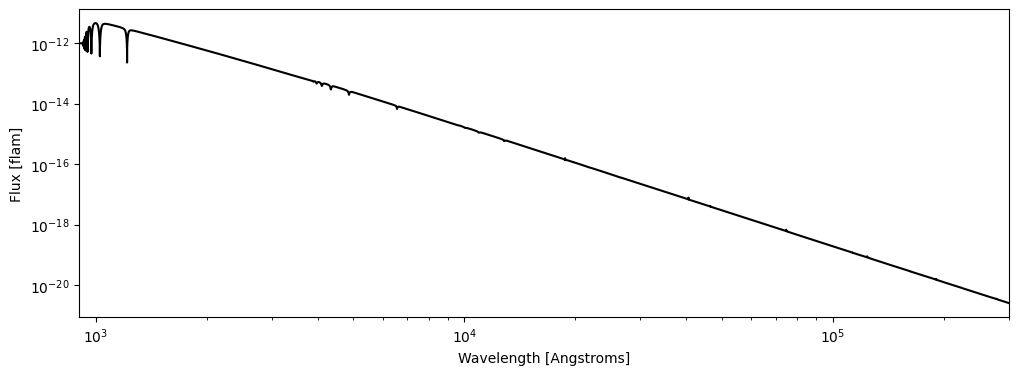

In [ ]:
model_wavs, model_flux, continuum_flux = ss.load_STIS_spectra(
    name = "GD153",
    debug = True,
)

By default, this will load the SED for all available wavelengths. If you only need a specific range of wavelengths, you can specify it using an optional argument...

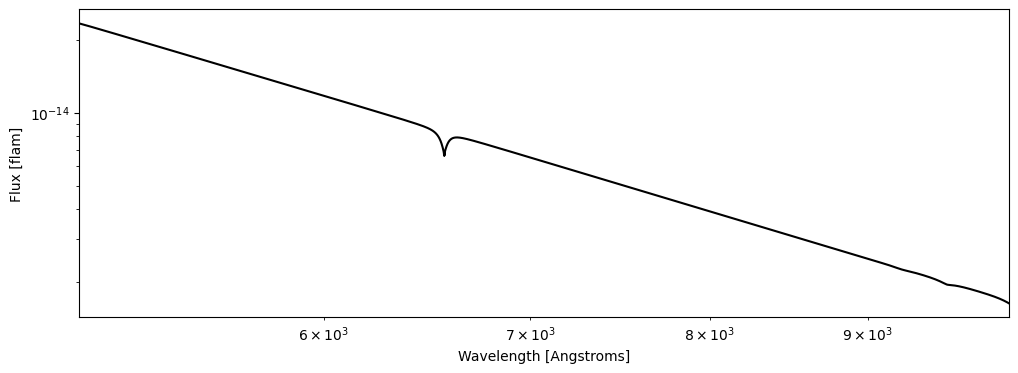

In [ ]:
import astropy.units as u

model_wavs, model_flux, _ = ss.load_STIS_spectra(
    name = "GD153",
    wavelength_bounds = [5000, 10000] * u.AA,
    debug = True,
)

Importantly, ```load_STIS_spectra()``` will load the model spectra by default. If you wanted a calibrated, measured SED for the star, you will need to indicate this using...

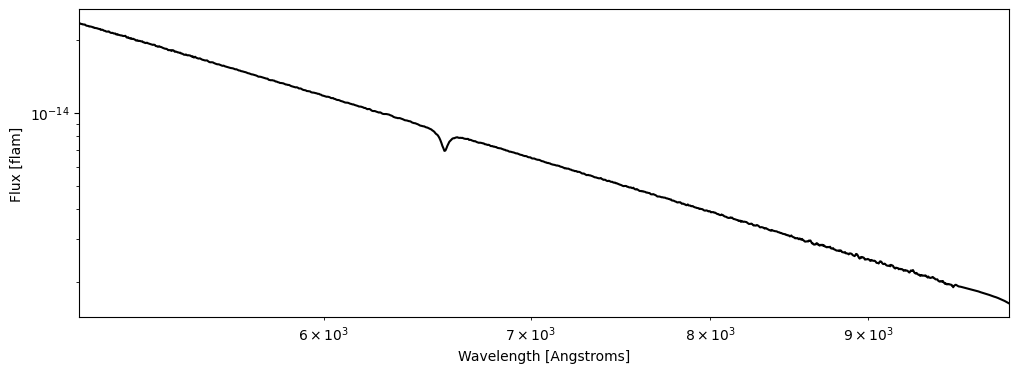

In [ ]:
_ = ss.load_STIS_spectra(
    name = "GD153",
    filetype = "stis",
    wavelength_bounds = [5000, 10000] * u.AA,
    debug = True,
)

Note that loading the "stis" SED will return seven total arguments (rather than the default three). These are...

> - Wavelength (Angstroms)
> - Flux (flam)
> - Statistical Error (flam)
> - Systematic Error (flam)
> - Full-Width Half Maximum (Angstroms)
> - Data Quality
> - Exposure Time (s)

Only the first two of these are needed for our flux calibration routines.

### _Generate a Flux Conversion_

Using the model SED, we can convert detector counts into physical flux units (in this example, flam). Assuming this conversion changes smoothly as a function of wavelength, we can model it using a low-order polynomial in ```generate_flux_conversion()```! Let's look at an example for GD153...

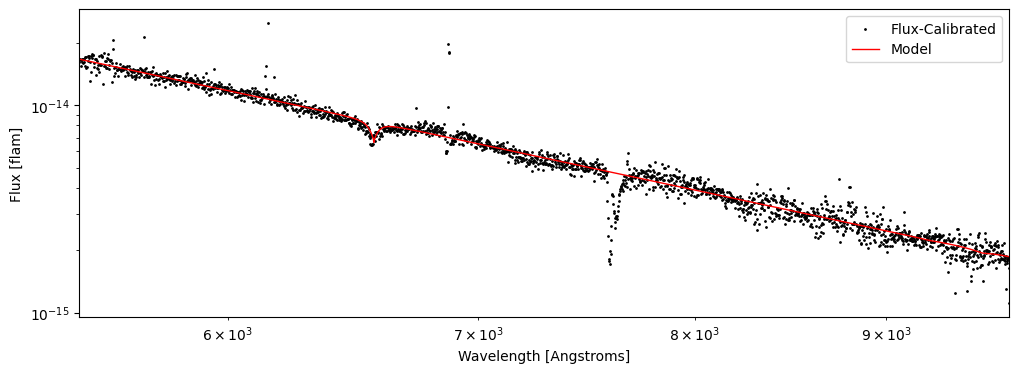

In [5]:
p_flux = ss.generate_flux_conversion(
    w_measured = measured_wavs, 
    w_model = model_wavs, 
    f_measured = flux_extracted, 
    f_model = model_flux,
    err = uncertainty_extracted,
    debug = True
)

The above plot shows your flux-calibrated data (black) against the provided model spectra (red). We can see that some features (such as the absorption feature around 7500 AA) still vary significantly from our model. These typically correspond to strong atmospheric absorptions that are not captured in the model spectra, and should not significantly impact the accuracy of the flux calibration.

```generate_flux_conversion()``` returns a Numpy polynomial that takes wavelength (units of Angstroms) as an argument, and returns the conversion factor from detector counts to flam. We can take a look at this model by itself before applying it to our data...

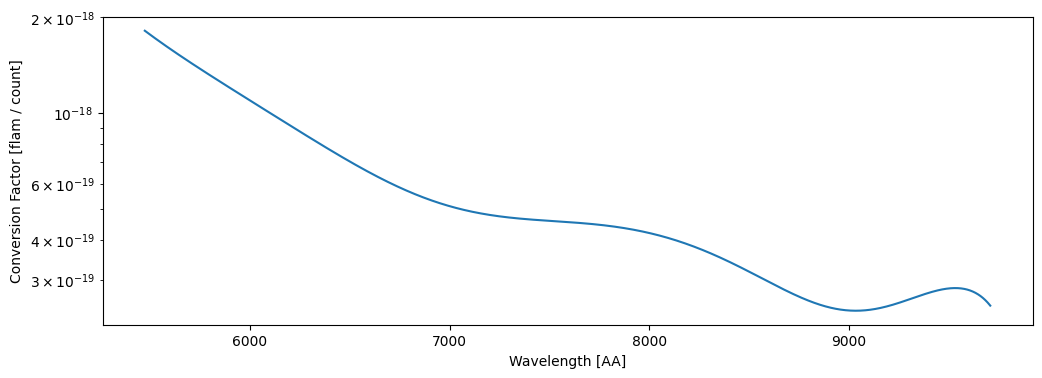

In [6]:
import matplotlib.pyplot as plt

conversion = p_flux(measured_wavs)

plt.plot(measured_wavs, conversion)
plt.xlabel("Wavelength [AA]")
plt.ylabel("Conversion Factor [flam / count]")
plt.yscale("log")
plt.show()

Then, to apply this flux calibration to our data, we simply multiply an extracted SED by this conversion factor...

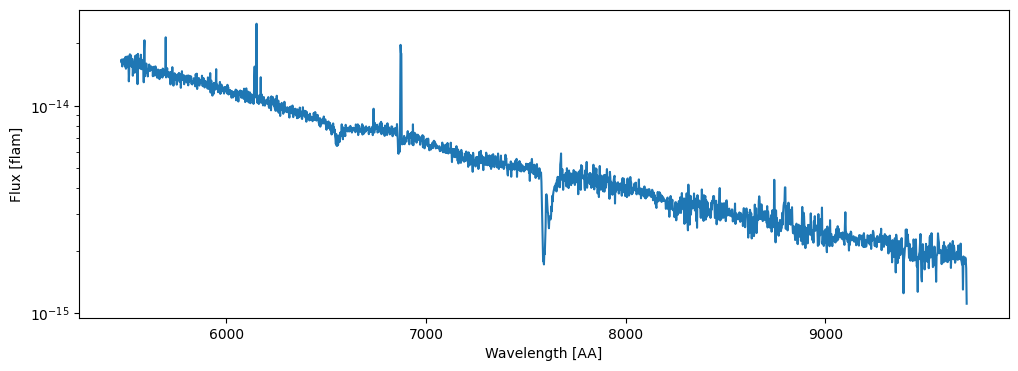

In [7]:
import matplotlib.pyplot as plt

conversion = p_flux(measured_wavs) * flux_extracted[0]

plt.plot(measured_wavs, conversion)
plt.xlabel("Wavelength [AA]")
plt.ylabel("Flux [flam]")
plt.yscale("log")
plt.show()

## __Common Errors__
### _Star not found in STIS Table_
If you attempt to load a model SED from the STIS website, but the name is not found in Table 1, then ```load_STIS_spectra()``` will throw an error. This function is reading in the raw HTML of the linked page and attempting to parse all of the names in the "Star name" column. For this reason, the loading function is very sensitive to the exact spelling of your provided ```name```. For example, if we insert an extra space in "GD153" we get...

In [ ]:
try:
    _ = ss.load_STIS_spectra(
        name = "GD 153",
        filetype = "stis",
        debug = True,
    )
except AssertionError as e:
    print(e)

Name 'GD 153' not found in table...


If you encounter this error, double-check that your provided ```name``` exactly matches an entry of Table 1 on the STIS website. If there is a match, but you are still encountering an error, then this may be an issue with our parser. Please tell us about this issue on the GitHub repository if you run into it!

### _Forgetting to specify units_
When specifying which portion of an STIS SED to load, it is easy to omit the units of your bounds. When you do so, it is impossible to infer which units you intended to provide, so we print a warning to the screen and return 'None'. For example...

In [9]:
_ = ss.load_STIS_spectra(
    name = "GD153",
    wavelength_bounds = [5000, 10000],
    debug = True,
)

Wavelength bounds must be astropy.Quantities, not '<class 'list'>'


If you run into this error, please make sure to multiply your bounds by an astropy quantity with units of length. All of the following are valid examples...

In [10]:
_ = ss.load_STIS_spectra(
    name = "GD153",
    wavelength_bounds = [5000, 10000] * u.AA,
)

_ = ss.load_STIS_spectra(
    name = "GD153",
    wavelength_bounds = [5000 * u.AA, 10000 * u.AA],
)

_ = ss.load_STIS_spectra(
    name = "GD153",
    wavelength_bounds = [500, 1000] * u.nm,
)

### _Misshappen Flux Calibration_
In some situations, you may already know the broad shape of your flux calibration curve. If this shape does not match the ```p_flux``` generated by ```generate_flux_conversion()```, one a several things may have gone wrong. The most common issue comes from a poor choice of ```order```...

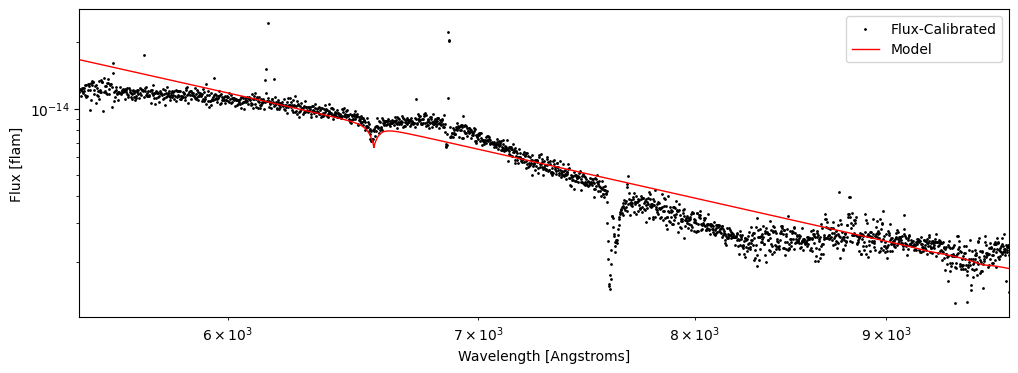

In [11]:
p_flux = ss.generate_flux_conversion(
    w_measured = measured_wavs, 
    w_model = model_wavs, 
    f_measured = flux_extracted, 
    f_model = model_flux,
    err = uncertainty_extracted,
    order = 2,
    debug = True
)

By default, the flux calibration will be a 7th order polynomial, but this may need some tweaking for your specific dataset. If you see that the red line (model) does a poor job describing your data, this should be your first check.

Another potential issue comes from the iterative sigma-clipping portion of the function. If you find that certain non-stellar features (i.e., atmospheric absorption bands) are strongly impacting the polynomial fit, you may need to decrease the ```sigma_clipping``` threshold or increase the ```max_iter``` parameter.